# Backend Trace Querying and Modeling 

## Prerequisites:
1. The Tempo service must be running.
2. The Tempo service must be accessible from the host where this script is running.
3. The Tempo service must have traces available for querying.


## Standard imports

In [97]:
import sys
import os
import pandas as pd
from typing import List, Dict


## Import our system

In [98]:

sys.path.append ('..')
import utils
utils.add_to_sys_path(os.path.join('..', '..', 'scale'))

from scale.backends import TraceBackend, TempoBackend

## Tempo Client Tests

### Constants

**Note** - verify your `minikube` ip, and adjust it below if needed

In [99]:
!minikube ip

192.168.49.2


In [100]:
# Constants
MINIKUBE_IP='192.168.49.2'
TEMPO_NODEPORT=32000

### Modeling Utilities
Right now, just converts the json to pandas dataframes

In [101]:
class Span:
    def __init__(self, trace_id, span_id, parent_id, operation_name, start_time, duration):
        self.trace_id = trace_id
        self.span_id = span_id
        self.parent_id = parent_id
        self.operation_name = operation_name
        self.start_time = start_time
        self.duration = duration
        self.tags = {}
        self.logs = []  
        

#### Convert the **`search_traces`** response to pandas dataframe

In [102]:
def trace_response_to_df(trace_response: List[Dict]) -> pd.DataFrame:
    trace_data = []
    for trace in trace_response:
        trace_data.append({
            'traceID': trace.get('traceID', None),
            'rootServiceName': trace.get('rootServiceName', None),
            'rootTraceName': trace.get('rootTraceName', None),
            'startTimeUnixNano': trace.get('startTimeUnixNano', None),
        })

    return pd.DataFrame(trace_data)

#### Convert **`get_trace_by_id`** to pandas dataframe

In [103]:
def model_trace_data(trace_data):
    spans_list = []
    
    for batch in trace_data['batches']:
        resource = {attr['key']: attr['value']['stringValue'] for attr in batch['resource']['attributes']}
        for scopeSpan in batch['scopeSpans']:
            scope_name = scopeSpan['scope']['name']
            scope_version = scopeSpan['scope'].get('version', None)
            
            for span in scopeSpan['spans']:
                span_info = {
                    'traceId': span['traceId'],
                    'spanId': span['spanId'],
                    'parentSpanId': span.get('parentSpanId'),
                    'name': span['name'],
                    'kind': span['kind'],
                    'startTimeUnixNano': span['startTimeUnixNano'],
                    'endTimeUnixNano': span['endTimeUnixNano'],
                    'service_name': resource.get('service.name'),
                    'scope_name': scope_name,
                    'scope_version': scope_version,
                }
                
                # Extract span attributes
                for attribute in span['attributes']:
                    key = attribute['key']
                    value = attribute['value'].get('stringValue') or attribute['value'].get('intValue')
                    span_info[key] = value
                
                spans_list.append(span_info)
    
    return pd.DataFrame(spans_list)

### Get Traces By Service

In [104]:
backend = TempoBackend(host=MINIKUBE_IP, port=TEMPO_NODEPORT)
query_args = {'service.name': 'Registration Service API'}
trace_query_result = backend.search_traces(**query_args)
traces_by_service_df = trace_response_to_df(trace_query_result)
traces_by_service_df

""


#### As pandas dataframe

In [105]:
trace_query_result_df = trace_response_to_df(trace_query_result)
trace_query_result_df.head()

""


### Get Traces By Operation *(name)*

In [106]:
backend = TempoBackend(host=MINIKUBE_IP, port=TEMPO_NODEPORT)
query_args = {'name': 'POST /enroll'}
trace_query_result = backend.search_traces(**query_args)
traces_by_operation_df = trace_response_to_df(trace_query_result)
traces_by_operation_df

,traceID,rootServiceName,rootTraceName,startTimeUnixNano
0,31c983e86775bb95c5dc6a4da4054a27,Registration Service,POST /enroll,1728690268737708986
1,1e74fd3d89379a590344660b1b16b216,Registration Service,POST /enroll,1728690267453934882
2,36ce7714955ae32596169d72408f5bcd,Registration Service,POST /enroll,1728690267441135085
3,9d91c8b520b70773b4c671dbaa5e2e9,Registration Service,POST /enroll,1728690266128948441
4,6946977e07c1cd6dd8e13f79e65b42f9,Registration Service,POST /enroll,1728690266043423203
5,43336efa5c568a63e4c625f8a2cffd95,Registration Service,POST /enroll,1728690230093898195
6,9e5863d1ceb781fd8ffc4260f77733ba,Registration Service,POST /enroll,1728690230091588161
7,f56e69819e3fb05a559a54987cd4cc16,Registration Service,POST /enroll,1728690230088239170
8,b60cb5b68a0f58ac946e5c1ec9967f85,Registration Service,POST /enroll,1728690227084915005
9,21223a02784ee84dd983e480644897c9,Registration Service,POST /enroll,1728690227082566025


### Show the a json `trace` response

In [107]:
first_trace_json = backend.get_trace_by_id(traces_by_operation_df['traceID'][0])
first_trace_json

{'batches': [{'resource': {'attributes': [{'key': 'service.name',
      'value': {'stringValue': 'Registration Service'}}]},
   'scopeSpans': [{'scope': {'name': 'opentelemetry.instrumentation.fastapi',
      'version': '0.48b0'},
     'spans': [{'traceId': 'McmD6Gd1u5XF3GpNpAVKJw==',
       'spanId': 'GGo3pYsUZo0=',
       'name': 'POST /enroll',
       'kind': 'SPAN_KIND_SERVER',
       'startTimeUnixNano': '1728690268737708986',
       'endTimeUnixNano': '1728690268747327046',
       'attributes': [{'key': 'http.scheme', 'value': {'stringValue': 'http'}},
        {'key': 'http.host', 'value': {'stringValue': '10.244.5.159:8000'}},
        {'key': 'net.host.port', 'value': {'intValue': '8000'}},
        {'key': 'http.flavor', 'value': {'stringValue': '1.1'}},
        {'key': 'http.target',
         'value': {'stringValue': '/api/v1/registration/enroll'}},
        {'key': 'http.server_name',
         'value': {'stringValue': '192.168.49.2:32285'}},
        {'key': 'http.user_agent',
 

### Make it a dataframe

In [108]:
first_trace_df = model_trace_data(first_trace_json)
first_trace_df

,traceId,spanId,parentSpanId,name,kind,startTimeUnixNano,endTimeUnixNano,service_name,scope_name,scope_version,...,db.system,db.statement,db.redis.database_index,net.transport,db.redis.args_length,celery.action,messaging.message.id,celery.task_name,messaging.destination_kind,messaging.destination
0,McmD6Gd1u5XF3GpNpAVKJw==,GGo3pYsUZo0=,None,POST /enroll,SPAN_KIND_SERVER,1728690268737708986,1728690268747327046,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,McmD6Gd1u5XF3GpNpAVKJw==,EmYTuiCjCjI=,GGo3pYsUZo0=,POST /enroll http receive,SPAN_KIND_INTERNAL,1728690268737893611,1728690268737920684,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,McmD6Gd1u5XF3GpNpAVKJw==,sYKtSY3o5Fw=,GGo3pYsUZo0=,POST /enroll http send,SPAN_KIND_INTERNAL,1728690268747039818,1728690268747215976,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,McmD6Gd1u5XF3GpNpAVKJw==,MGnXA6sNvZw=,GGo3pYsUZo0=,POST /enroll http send,SPAN_KIND_INTERNAL,1728690268747277118,1728690268747317810,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,McmD6Gd1u5XF3GpNpAVKJw==,xuyywOhVgXU=,GGo3pYsUZo0=,GET,SPAN_KIND_CLIENT,1728690268738491336,1728690268742645280,Registration Service,opentelemetry.instrumentation.urllib3,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,McmD6Gd1u5XF3GpNpAVKJw==,V9ZGqOjjER0=,GGo3pYsUZo0=,POST,SPAN_KIND_CLIENT,1728690268743397253,1728690268746781882,Registration Service,opentelemetry.instrumentation.urllib3,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,McmD6Gd1u5XF3GpNpAVKJw==,J3Pl7PPhUls=,xuyywOhVgXU=,GET /validate_user,SPAN_KIND_SERVER,1728690268739574997,1728690268741993620,Authorization Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,McmD6Gd1u5XF3GpNpAVKJw==,QubZ2susE/U=,J3Pl7PPhUls=,GET /validate_user http send,SPAN_KIND_INTERNAL,1728690268741780022,1728690268741911514,Authorization Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,McmD6Gd1u5XF3GpNpAVKJw==,EZlGewkuqco=,J3Pl7PPhUls=,GET /validate_user http send,SPAN_KIND_INTERNAL,1728690268741953921,1728690268741985542,Authorization Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,McmD6Gd1u5XF3GpNpAVKJw==,xzR69079Y7Q=,J3Pl7PPhUls=,connect,SPAN_KIND_CLIENT,1728690268740399087,1728690268740481532,Authorization Service,opentelemetry.instrumentation.sqlalchemy,0.48b0,...,postgresql,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get All Recent Traces

In [109]:
from datetime import datetime, timedelta
now = datetime.now()
start = now - timedelta(minutes=3)
query_args = {
    'start': int(start.timestamp()), 
    'end': int(now.timestamp()),
    'limit': 3000,   
}
trace_query_result = backend.search_traces(**query_args)
recent_traces_df = trace_response_to_df(trace_query_result)
recent_traces_df.head()

,traceID,rootServiceName,rootTraceName,startTimeUnixNano
0,288cd587ed544e57cad28c08892e1aaf,Registration Service,POST /verify,1728690269972623096
1,8c442b47da3cd9801b80be840b5270a1,Registration Service,POST /enroll,1728690269163391071
2,5289b9d9d89e7f92aff31355292b108,<root span not yet received>,None,1728690269157840474
3,400ce90f68e2524a843d629a269523c5,Registration Service,POST /verify,1728690268761668378
4,ab722837b7ae8c1f854c8c7bb98296e,Registration Service,POST /verify,1728690268759519947


In [110]:
# pick which query to run with 
#traces_df = traces_by_service_df
#traces_df = traces_by_operation_df
traces_df = recent_traces_df
len(traces_df)


128

In [111]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np

if len(traces_df) < 250:
    batch_size = len(traces_df)
elif len(traces_df) < 500:
    batch_size = len(traces_df) // 3
else:
    batch_size = 250

def process_batch(trace_ids, backend):
    trace_data_batch = []
    for trace_id in trace_ids:
        trace_data_batch.append(model_trace_data(backend.get_trace_by_id(trace_id)))
    return pd.concat(trace_data_batch, ignore_index=True)

def process_in_batches(traces_df: pd.DataFrame, backend: TraceBackend, batch_size=250):
    # Split trace IDs into batches of 250
    trace_batches = np.array_split(traces_df['traceID'], len(traces_df) // batch_size + 1)
    
    trace_data = []

    # Use ThreadPoolExecutor for parallel processing of batches
    with ThreadPoolExecutor() as executor:
        # Submit each batch to the executor
        futures = [executor.submit(process_batch, batch, backend) for batch in trace_batches]

        # Collect results as they complete
        for future in futures:
            trace_data.append(future.result())

    # Concatenate all the data into a single DataFrame
    trace_data_df = pd.concat(trace_data, ignore_index=True)
    return trace_data_df

span_df = process_in_batches(traces_df, backend=backend, batch_size=batch_size)
span_df.head()


# aggregate all traces into a single dataframe
###########################################################################################
# single-threaded version

# trace_data = []
# for trace_id in traces_df['traceID']:
#     trace_data.append(model_trace_data(backend.get_trace_by_id(trace_id)))
    
# trace_data_df = pd.concat(trace_data, ignore_index=True)
# trace_data_df.head()

/home/johnny/dev/cs598-project/tests/.tests/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


,traceId,spanId,parentSpanId,name,kind,startTimeUnixNano,endTimeUnixNano,service_name,scope_name,scope_version,...,net.transport,db.redis.args_length,db.name,db.user,celery.action,messaging.message.id,celery.task_name,messaging.destination_kind,messaging.destination,db.redis.pipeline_length
0,KIzVh+1UTlfK0owIiS4arw==,+pp2QKWwKl4=,uyQmjNSH/xM=,POST /verify http receive,SPAN_KIND_INTERNAL,1728690269972762460,1728690269972782007,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KIzVh+1UTlfK0owIiS4arw==,JTpBanMdK88=,uyQmjNSH/xM=,POST /verify http send,SPAN_KIND_INTERNAL,1728690269973680871,1728690269973820836,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KIzVh+1UTlfK0owIiS4arw==,9w+ee6kZ7Ls=,uyQmjNSH/xM=,POST /verify http send,SPAN_KIND_INTERNAL,1728690269973861883,1728690269973895494,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KIzVh+1UTlfK0owIiS4arw==,uyQmjNSH/xM=,None,POST /verify,SPAN_KIND_SERVER,1728690269972623096,1728690269973906921,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KIzVh+1UTlfK0owIiS4arw==,A/MJOiQOS94=,uyQmjNSH/xM=,GET,SPAN_KIND_CLIENT,1728690269973068240,1728690269973315531,Registration Service,opentelemetry.instrumentation.redis,0.48b0,...,ip_tcp,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
len(span_df)

612

### Unique Services

In [113]:
unique_nodes = span_df['service_name'].unique()
unique_nodes

array(['Registration Service', 'Authorization Service', 'Tasking Service',
       'Transactions Service', 'Notification Service',
       'DataManagement Service'], dtype=object)

### Derived column for span types

In [114]:
# Add a new column for span type based on 'kind'
span_df['span_type'] = span_df['kind'].map({
    'SPAN_KIND_SERVER': 'Server',
    'SPAN_KIND_CLIENT': 'Client',
    'SPAN_KIND_PRODUCER': 'Producer',
    'SPAN_KIND_CONSUMER': 'Consumer',
    'SPAN_KIND_INTERNAL': 'Internal'
})

print(span_df[['traceId', 'spanId', 'span_type']].head())


                    traceId        spanId span_type
0  KIzVh+1UTlfK0owIiS4arw==  +pp2QKWwKl4=  Internal
1  KIzVh+1UTlfK0owIiS4arw==  JTpBanMdK88=  Internal
2  KIzVh+1UTlfK0owIiS4arw==  9w+ee6kZ7Ls=  Internal
3  KIzVh+1UTlfK0owIiS4arw==  uyQmjNSH/xM=    Server
4  KIzVh+1UTlfK0owIiS4arw==  A/MJOiQOS94=    Client


### Convert the traceId to hex for debugging and visualization
Useful if you wanted to manually pick an indidual trace and copy that traceId to call `backend.get_trace_by_id`
The values are encoded in base64, so it won't work without converting.
For example: 

this is what we'll see in when we print the dataframe

```bash
                    traceId        spanId span_type
0   KGP8EtGlflQJpvlcucs92Q==  kdOBNDS7zxM=  Internal
```

But this is the value we want:

```bash
                    traceId               spanId   span_type
0  2863fc12d1a57e5409a6f95cb9cb3dd9  kdOBNDS7zxM=  Internal
```



In [115]:
import base64
# Function to decode Base64 to hex
def base64_to_hex(b64_string):
    # Decode the Base64 string to bytes
    byte_data = base64.b64decode(b64_string)
    
    # Convert bytes to hex
    hex_string = byte_data.hex()
    
    return hex_string

span_df['traceId'] = span_df['traceId'].apply(base64_to_hex)


### Add span durations to the dataframe

**Note** - I've set the root span to 0 because its duration is the entire trace.  It messes up other calculations, like trying to aggregate spans to calculate a total service time.   

In [116]:

# the data types are all objects so we need to convert them to the correct data types
span_df['startTimeUnixNano'] = pd.to_numeric(span_df['startTimeUnixNano'])
span_df['endTimeUnixNano'] = pd.to_numeric(span_df['endTimeUnixNano'])

# Calculate the duration in milliseconds (nanoseconds to milliseconds conversion)
span_df['span_duration_ms'] = (span_df['endTimeUnixNano'] - span_df['startTimeUnixNano']) / 1e6

# Set span_duration_ms to 0 where 'parentSpanId' is None
span_df.loc[span_df['parentSpanId'].isna(), 'span_duration_ms'] = 0

# Display the updated DataFrame
span_df[['traceId', 'spanId', 'name', 'startTimeUnixNano', 'endTimeUnixNano', 'span_duration_ms']]



,traceId,spanId,name,startTimeUnixNano,endTimeUnixNano,span_duration_ms
0,288cd587ed544e57cad28c08892e1aaf,+pp2QKWwKl4=,POST /verify http receive,1728690269972762460,1728690269972782007,0.019547
1,288cd587ed544e57cad28c08892e1aaf,JTpBanMdK88=,POST /verify http send,1728690269973680871,1728690269973820836,0.139965
2,288cd587ed544e57cad28c08892e1aaf,9w+ee6kZ7Ls=,POST /verify http send,1728690269973861883,1728690269973895494,0.033611
3,288cd587ed544e57cad28c08892e1aaf,uyQmjNSH/xM=,POST /verify,1728690269972623096,1728690269973906921,0.000000
4,288cd587ed544e57cad28c08892e1aaf,A/MJOiQOS94=,GET,1728690269973068240,1728690269973315531,0.247291
...,...,...,...,...,...,...
607,6c30731beca5d38fd34a4858c85c5348,1FBj038xogs=,GET /health http send,1728690207799253126,1728690207799301853,0.048727
608,6c30731beca5d38fd34a4858c85c5348,Qp+L8qSN0YQ=,GET /health,1728690207789593246,1728690207799316424,0.000000
609,fea2a871d217b007356fc2f63c341c78,BdWXFOSCQJw=,GET /health http send,1728690207679634511,1728690207682192868,2.558357
610,fea2a871d217b007356fc2f63c341c78,pnGVOy39vIQ=,GET /health http send,1728690207682366578,1728690207682446193,0.079615


### Add time-in-service

In [117]:
# Calculate the total duration per traceId and service_name
span_df['service_duration_ms'] = span_df.groupby(['traceId', 'service_name'])['span_duration_ms'].transform('sum')

# Show the updated DataFrame
span_df[['traceId', 'spanId', 'name', 'service_name', 'span_duration_ms', 'service_duration_ms']]



,traceId,spanId,name,service_name,span_duration_ms,service_duration_ms
0,288cd587ed544e57cad28c08892e1aaf,+pp2QKWwKl4=,POST /verify http receive,Registration Service,0.019547,0.626186
1,288cd587ed544e57cad28c08892e1aaf,JTpBanMdK88=,POST /verify http send,Registration Service,0.139965,0.626186
2,288cd587ed544e57cad28c08892e1aaf,9w+ee6kZ7Ls=,POST /verify http send,Registration Service,0.033611,0.626186
3,288cd587ed544e57cad28c08892e1aaf,uyQmjNSH/xM=,POST /verify,Registration Service,0.000000,0.626186
4,288cd587ed544e57cad28c08892e1aaf,A/MJOiQOS94=,GET,Registration Service,0.247291,0.626186
...,...,...,...,...,...,...
607,6c30731beca5d38fd34a4858c85c5348,1FBj038xogs=,GET /health http send,Transactions Service,0.048727,0.423446
608,6c30731beca5d38fd34a4858c85c5348,Qp+L8qSN0YQ=,GET /health,Transactions Service,0.000000,0.423446
609,fea2a871d217b007356fc2f63c341c78,BdWXFOSCQJw=,GET /health http send,Tasking Service,2.558357,2.637972
610,fea2a871d217b007356fc2f63c341c78,pnGVOy39vIQ=,GET /health http send,Tasking Service,0.079615,2.637972


### End-to-end trace duration

In [118]:

def trace_duration_ms(trace_data_df):
    trace_start = trace_data_df['startTimeUnixNano'].min()
    trace_end = trace_data_df['endTimeUnixNano'].max()
    return (trace_end - trace_start) / 1e6

# Use transform to apply the duration calculation to each group
span_df['trace_duration_ms'] = span_df.groupby('traceId')['startTimeUnixNano'].transform(lambda x: trace_duration_ms(span_df[span_df['traceId'] == x.name]))
span_df[['traceId', 'service_name', 'trace_duration_ms']].drop_duplicates().head(15)


,traceId,service_name,trace_duration_ms
0,288cd587ed544e57cad28c08892e1aaf,Registration Service,1.283825
6,8c442b47da3cd9801b80be840b5270a1,Registration Service,807.395980
12,8c442b47da3cd9801b80be840b5270a1,Authorization Service,807.395980
18,8c442b47da3cd9801b80be840b5270a1,Tasking Service,807.395980
24,05289b9d9d89e7f92aff31355292b108,Authorization Service,399.827141
33,05289b9d9d89e7f92aff31355292b108,Tasking Service,399.827141
39,400ce90f68e2524a843d629a269523c5,Registration Service,1.290242
45,0ab722837b7ae8c1f854c8c7bb98296e,Registration Service,1.668646
51,32d74b6076e70166ec4a641d5a8e9f5e,Registration Service,1.282458
57,ef360d64f7827c39059a7e1b07597bcb,Registration Service,9.547218


### Percentage of time in each service

In [119]:
def avg_time_per_service(traces_df: pd.DataFrame) -> pd.DataFrame:
    # Group by traceId and service_name to calculate time spent in each service per trace
    service_time = traces_df.groupby(['traceId', 'service_name'])['span_duration_ms'].sum().reset_index()

    # Use the trace_duration_ms column that exists in the main DataFrame
    trace_durations = traces_df[['traceId', 'trace_duration_ms']].drop_duplicates()
    # print (trace_durations)

    # Merge the service time with the overall trace duration from the main DataFrame
    service_time = service_time.merge(trace_durations, on='traceId')

    # Calculate the percentage of time spent in each service for the trace
    service_time['percent_time_in_service'] = (service_time['span_duration_ms'] / service_time['trace_duration_ms']) * 100

    return service_time[['traceId', 'service_name', 'percent_time_in_service']]

avg_service_times_df = avg_time_per_service(span_df)
avg_service_times_df.sort_values('percent_time_in_service', ascending=False)


,traceId,service_name,percent_time_in_service
87,8f0e3ab4079f5efc0d3f78a4a4ce3718,Registration Service,99.810926
83,8c442b47da3cd9801b80be840b5270a1,Registration Service,99.808882
148,fe4c7cd052236924bd2064521dd06cc0,Registration Service,99.765213
64,6946977e07c1cd6dd8e13f79e65b42f9,Registration Service,97.139329
28,1e74fd3d89379a590344660b1b16b216,Registration Service,90.202035
...,...,...,...
96,a10a85309fbe2fd863b203f332975276,DataManagement Service,0.000000
92,926ee9ffb903bf407731a17b45e56bb6,Authorization Service,0.000000
124,d66c56672db3ca5fc722b70b2a0fb49e,Authorization Service,0.000000
132,e5b8f4eecff0675d98bb7e198c2c22a7,Authorization Service,0.000000


Service latency / bottlenecks

In [120]:
# Group by traceId and service_name and calculate average latency per service for each trace
service_latency = span_df.groupby(['traceId', 'service_name'])['span_duration_ms'].mean().reset_index(name='avg_latency_ms')

# Merge the average latency back into the original DataFrame
span_df = span_df.merge(service_latency, on=['traceId', 'service_name'], suffixes=('', '_avg_service'))

# Find services with high latency per trace (avg_latency_ms > 200 ms)
high_latency_services = service_latency[service_latency['avg_latency_ms'] > 200]

# Display the results
print(service_latency.sort_values('avg_latency_ms', ascending=False).head())
high_latency_services



                              traceId          service_name  avg_latency_ms
87   8f0e3ab4079f5efc0d3f78a4a4ce3718  Registration Service      119.925335
148  fe4c7cd052236924bd2064521dd06cc0  Registration Service      119.167525
83   8c442b47da3cd9801b80be840b5270a1  Registration Service      115.121842
64   6946977e07c1cd6dd8e13f79e65b42f9  Registration Service        9.713188
65   6946977e07c1cd6dd8e13f79e65b42f9       Tasking Service        5.358656


,traceId,service_name,avg_latency_ms


In [121]:
span_df

,traceId,spanId,parentSpanId,name,kind,startTimeUnixNano,endTimeUnixNano,service_name,scope_name,scope_version,...,messaging.message.id,celery.task_name,messaging.destination_kind,messaging.destination,db.redis.pipeline_length,span_type,span_duration_ms,service_duration_ms,trace_duration_ms,avg_latency_ms
0,288cd587ed544e57cad28c08892e1aaf,+pp2QKWwKl4=,uyQmjNSH/xM=,POST /verify http receive,SPAN_KIND_INTERNAL,1728690269972762460,1728690269972782007,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.019547,0.626186,1.283825,0.104364
1,288cd587ed544e57cad28c08892e1aaf,JTpBanMdK88=,uyQmjNSH/xM=,POST /verify http send,SPAN_KIND_INTERNAL,1728690269973680871,1728690269973820836,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.139965,0.626186,1.283825,0.104364
2,288cd587ed544e57cad28c08892e1aaf,9w+ee6kZ7Ls=,uyQmjNSH/xM=,POST /verify http send,SPAN_KIND_INTERNAL,1728690269973861883,1728690269973895494,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.033611,0.626186,1.283825,0.104364
3,288cd587ed544e57cad28c08892e1aaf,uyQmjNSH/xM=,None,POST /verify,SPAN_KIND_SERVER,1728690269972623096,1728690269973906921,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Server,0.000000,0.626186,1.283825,0.104364
4,288cd587ed544e57cad28c08892e1aaf,A/MJOiQOS94=,uyQmjNSH/xM=,GET,SPAN_KIND_CLIENT,1728690269973068240,1728690269973315531,Registration Service,opentelemetry.instrumentation.redis,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Client,0.247291,0.626186,1.283825,0.104364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,6c30731beca5d38fd34a4858c85c5348,1FBj038xogs=,Qp+L8qSN0YQ=,GET /health http send,SPAN_KIND_INTERNAL,1728690207799253126,1728690207799301853,Transactions Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.048727,0.423446,9.723178,0.141149
608,6c30731beca5d38fd34a4858c85c5348,Qp+L8qSN0YQ=,None,GET /health,SPAN_KIND_SERVER,1728690207789593246,1728690207799316424,Transactions Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Server,0.000000,0.423446,9.723178,0.141149
609,fea2a871d217b007356fc2f63c341c78,BdWXFOSCQJw=,3m5FBNsFoq4=,GET /health http send,SPAN_KIND_INTERNAL,1728690207679634511,1728690207682192868,Tasking Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,2.558357,2.637972,10.942125,0.879324
610,fea2a871d217b007356fc2f63c341c78,pnGVOy39vIQ=,3m5FBNsFoq4=,GET /health http send,SPAN_KIND_INTERNAL,1728690207682366578,1728690207682446193,Tasking Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.079615,2.637972,10.942125,0.879324


In [122]:
graph_df = span_df[['service_name', 'traceId', 'spanId', 'parentSpanId']]

graph_df

,service_name,traceId,spanId,parentSpanId
0,Registration Service,288cd587ed544e57cad28c08892e1aaf,+pp2QKWwKl4=,uyQmjNSH/xM=
1,Registration Service,288cd587ed544e57cad28c08892e1aaf,JTpBanMdK88=,uyQmjNSH/xM=
2,Registration Service,288cd587ed544e57cad28c08892e1aaf,9w+ee6kZ7Ls=,uyQmjNSH/xM=
3,Registration Service,288cd587ed544e57cad28c08892e1aaf,uyQmjNSH/xM=,None
4,Registration Service,288cd587ed544e57cad28c08892e1aaf,A/MJOiQOS94=,uyQmjNSH/xM=
...,...,...,...,...
607,Transactions Service,6c30731beca5d38fd34a4858c85c5348,1FBj038xogs=,Qp+L8qSN0YQ=
608,Transactions Service,6c30731beca5d38fd34a4858c85c5348,Qp+L8qSN0YQ=,None
609,Tasking Service,fea2a871d217b007356fc2f63c341c78,BdWXFOSCQJw=,3m5FBNsFoq4=
610,Tasking Service,fea2a871d217b007356fc2f63c341c78,pnGVOy39vIQ=,3m5FBNsFoq4=


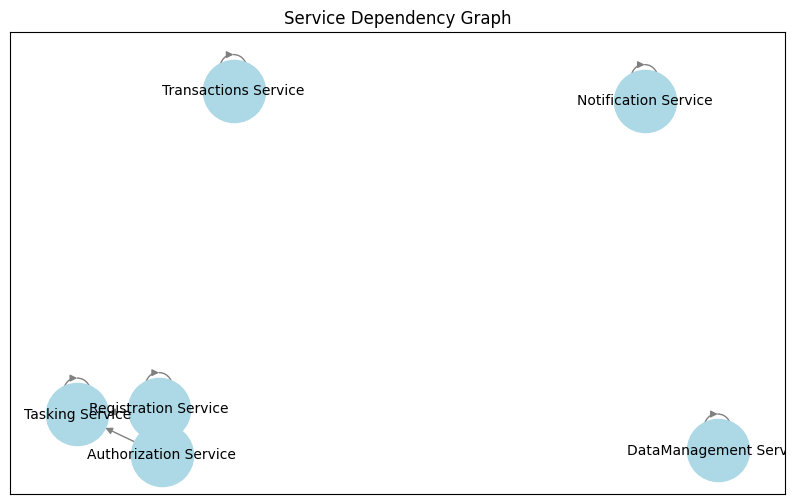

,traceId,spanId,parentSpanId,name,kind,startTimeUnixNano,endTimeUnixNano,service_name,scope_name,scope_version,...,messaging.message.id,celery.task_name,messaging.destination_kind,messaging.destination,db.redis.pipeline_length,span_type,span_duration_ms,service_duration_ms,trace_duration_ms,avg_latency_ms
0,288cd587ed544e57cad28c08892e1aaf,+pp2QKWwKl4=,uyQmjNSH/xM=,POST /verify http receive,SPAN_KIND_INTERNAL,1728690269972762460,1728690269972782007,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.019547,0.626186,1.283825,0.104364
1,288cd587ed544e57cad28c08892e1aaf,JTpBanMdK88=,uyQmjNSH/xM=,POST /verify http send,SPAN_KIND_INTERNAL,1728690269973680871,1728690269973820836,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.139965,0.626186,1.283825,0.104364
2,288cd587ed544e57cad28c08892e1aaf,9w+ee6kZ7Ls=,uyQmjNSH/xM=,POST /verify http send,SPAN_KIND_INTERNAL,1728690269973861883,1728690269973895494,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.033611,0.626186,1.283825,0.104364
3,288cd587ed544e57cad28c08892e1aaf,uyQmjNSH/xM=,None,POST /verify,SPAN_KIND_SERVER,1728690269972623096,1728690269973906921,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Server,0.000000,0.626186,1.283825,0.104364
4,288cd587ed544e57cad28c08892e1aaf,A/MJOiQOS94=,uyQmjNSH/xM=,GET,SPAN_KIND_CLIENT,1728690269973068240,1728690269973315531,Registration Service,opentelemetry.instrumentation.redis,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Client,0.247291,0.626186,1.283825,0.104364
5,288cd587ed544e57cad28c08892e1aaf,Yzn5zc+1gdU=,uyQmjNSH/xM=,DEL,SPAN_KIND_CLIENT,1728690269973381672,1728690269973567444,Registration Service,opentelemetry.instrumentation.redis,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Client,0.185772,0.626186,1.283825,0.104364
6,8c442b47da3cd9801b80be840b5270a1,D0LmOY01+Ns=,None,POST /enroll,SPAN_KIND_SERVER,1728690269163391071,1728690269970787051,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Server,0.000000,805.852897,807.395980,115.121842
7,8c442b47da3cd9801b80be840b5270a1,ojc3Yf1JAMs=,D0LmOY01+Ns=,POST /enroll http receive,SPAN_KIND_INTERNAL,1728690269163599159,1728690269163626103,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.026944,805.852897,807.395980,115.121842
8,8c442b47da3cd9801b80be840b5270a1,5TDBqTrrZho=,D0LmOY01+Ns=,POST /enroll http send,SPAN_KIND_INTERNAL,1728690269970503697,1728690269970681526,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.177829,805.852897,807.395980,115.121842
9,8c442b47da3cd9801b80be840b5270a1,y2xhfpECz6A=,D0LmOY01+Ns=,POST /enroll http send,SPAN_KIND_INTERNAL,1728690269970731393,1728690269970777883,Registration Service,opentelemetry.instrumentation.fastapi,0.48b0,...,NaN,NaN,NaN,NaN,NaN,Internal,0.046490,805.852897,807.395980,115.121842


In [123]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Iterate over the DataFrame and add edges between services based on parentSpanId and spanId
for _, row in span_df.iterrows():
    # Only create an edge if the parentSpanId is not None
    if row['parentSpanId'] is not None and row['parentSpanId'] != 'None':
        parent_span = row['parentSpanId']
        child_span = row['spanId']
        
        # Get the service names of the parent and the current node
        parent_service = span_df[span_df['spanId'] == parent_span]['service_name'].values
        child_service = row['service_name']
        
        if len(parent_service) > 0:  # Ensure the parent exists in the DataFrame
            parent_service = parent_service[0]
            # Add an edge from the parent service to the child service
            G.add_edge(parent_service, child_service)

# Plot the graph
plt.figure(figsize=(10, 6))
nx.draw_networkx(G, with_labels=True, node_color='lightblue', font_size=10, node_size=2000, edge_color='gray')
plt.title('Service Dependency Graph')
plt.show()
span_df.head(25)

In [124]:
data = {'resource_spans': [{'resource': {'attributes': [{'key': 'service.name', 'value': {'string_value': 'Transactions Service'}}]}, 'scope_spans': [{'scope': {'name': 'opentelemetry.instrumentation.urllib3', 'version': '0.48b0'}, 'spans': [{'trace_id': 'Ev88t/0K0nxmDIWb0KLgcw==', 'span_id': 'iEn1rKprKRE=', 'parent_span_id': '4uwjSOlwu8k=', 'name': 'GET', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641400781612', 'end_time_unix_nano': '1728445641790372463', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.url', 'value': {'string_value': 'http://auth:8080/api/v1/auth/authorize'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'Ev88t/0K0nxmDIWb0KLgcw==', 'span_id': '47vE3kW5294=', 'parent_span_id': '4uwjSOlwu8k=', 'name': 'POST', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641791142985', 'end_time_unix_nano': '1728445641794027783', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.url', 'value': {'string_value': 'http://tasking:8080/internal/v1/tasks/process_transaction'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'O2fG/JFKjg22jAUZF2NMow==', 'span_id': 'XmxzKIWDLrg=', 'parent_span_id': 'UnAyM3fDJhk=', 'name': 'GET', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641806871456', 'end_time_unix_nano': '1728445641809040148', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.url', 'value': {'string_value': 'http://auth:8080/api/v1/auth/authorize'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'O2fG/JFKjg22jAUZF2NMow==', 'span_id': 'Gd1yTeFDqEE=', 'parent_span_id': 'UnAyM3fDJhk=', 'name': 'POST', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641809959626', 'end_time_unix_nano': '1728445641813349330', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.url', 'value': {'string_value': 'http://tasking:8080/internal/v1/tasks/process_transaction'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'BVsxqxlVyog=', 'parent_span_id': '4iI/3sPAJoI=', 'name': 'GET', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641817776483', 'end_time_unix_nano': '1728445641820034275', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.url', 'value': {'string_value': 'http://auth:8080/api/v1/auth/authorize'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'gJUFyoPvhes=', 'parent_span_id': '4iI/3sPAJoI=', 'name': 'GET', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641820919454', 'end_time_unix_nano': '1728445641824377971', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.url', 'value': {'string_value': 'http://dms:8080/internal/v1/data/transactions?user_id=100&skip=0&limit=10'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'f6fADiNr2HFn9RmwSWoBaw==', 'span_id': 'bpPnPzGtcGs=', 'parent_span_id': '8UpTIlDV58c=', 'name': 'GET', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641842079689', 'end_time_unix_nano': '1728445641845147266', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.url', 'value': {'string_value': 'http://auth:8080/api/v1/auth/authorize'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'f6fADiNr2HFn9RmwSWoBaw==', 'span_id': 'ScJUI7gHQLM=', 'parent_span_id': '8UpTIlDV58c=', 'name': 'POST', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641845999553', 'end_time_unix_nano': '1728445641849548463', 'attributes': [{'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.url', 'value': {'string_value': 'http://tasking:8080/internal/v1/tasks/process_transaction'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}]}, {'scope': {'name': 'opentelemetry.instrumentation.fastapi', 'version': '0.48b0'}, 'spans': [{'trace_id': 'Ev88t/0K0nxmDIWb0KLgcw==', 'span_id': 'gZt9eq8OJ9A=', 'parent_span_id': '4uwjSOlwu8k=', 'name': 'POST / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641794450135', 'end_time_unix_nano': '1728445641794606397', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'Ev88t/0K0nxmDIWb0KLgcw==', 'span_id': '/5k3q8cys0M=', 'parent_span_id': '4uwjSOlwu8k=', 'name': 'POST / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641794652513', 'end_time_unix_nano': '1728445641794690508', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'Ev88t/0K0nxmDIWb0KLgcw==', 'span_id': '4uwjSOlwu8k=', 'name': 'POST /', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641399820561', 'end_time_unix_nano': '1728445641794698966', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.208:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/api/v1/transactions/'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.208:8000/api/v1/transactions/'}}, {'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.server_name', 'value': {'string_value': '192.168.49.2:31834'}}, {'key': 'http.user_agent', 'value': {'string_value': 'python-requests/2.32.3'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.0.1'}}, {'key': 'net.peer.port', 'value': {'int_value': '51197'}}, {'key': 'http.route', 'value': {'string_value': '/'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'O2fG/JFKjg22jAUZF2NMow==', 'span_id': 'giCDn3up3Do=', 'parent_span_id': 'UnAyM3fDJhk=', 'name': 'POST / http receive', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641806154040', 'end_time_unix_nano': '1728445641806185285', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.request'}}], 'status': {}, 'flags': 256}, {'trace_id': 'O2fG/JFKjg22jAUZF2NMow==', 'span_id': 'QM9MhAouQdo=', 'parent_span_id': 'UnAyM3fDJhk=', 'name': 'POST / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641813896161', 'end_time_unix_nano': '1728445641814124668', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'O2fG/JFKjg22jAUZF2NMow==', 'span_id': 'q+6KCBuqQsc=', 'parent_span_id': 'UnAyM3fDJhk=', 'name': 'POST / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641814192997', 'end_time_unix_nano': '1728445641814244900', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'O2fG/JFKjg22jAUZF2NMow==', 'span_id': 'UnAyM3fDJhk=', 'name': 'POST /', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641805926259', 'end_time_unix_nano': '1728445641814257241', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.208:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/api/v1/transactions/'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.208:8000/api/v1/transactions/'}}, {'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.server_name', 'value': {'string_value': '192.168.49.2:31834'}}, {'key': 'http.user_agent', 'value': {'string_value': 'python-requests/2.32.3'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.0.1'}}, {'key': 'net.peer.port', 'value': {'int_value': '2240'}}, {'key': 'http.route', 'value': {'string_value': '/'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': '3l891zbctIE=', 'parent_span_id': '4iI/3sPAJoI=', 'name': 'GET / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641824945942', 'end_time_unix_nano': '1728445641825149097', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'HpgJxX/nCik=', 'parent_span_id': '4iI/3sPAJoI=', 'name': 'GET / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641825212421', 'end_time_unix_nano': '1728445641825259898', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': '4iI/3sPAJoI=', 'name': 'GET /', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641817113209', 'end_time_unix_nano': '1728445641825272370', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.208:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/api/v1/transactions/'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.208:8000/api/v1/transactions/'}}, {'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.server_name', 'value': {'string_value': '192.168.49.2:31834'}}, {'key': 'http.user_agent', 'value': {'string_value': 'python-requests/2.32.3'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.0.1'}}, {'key': 'net.peer.port', 'value': {'int_value': '44626'}}, {'key': 'http.route', 'value': {'string_value': '/'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'f6fADiNr2HFn9RmwSWoBaw==', 'span_id': 'WkaDO5xGN3g=', 'parent_span_id': '8UpTIlDV58c=', 'name': 'POST / http receive', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641841434416', 'end_time_unix_nano': '1728445641841521908', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.request'}}], 'status': {}, 'flags': 256}, {'trace_id': 'f6fADiNr2HFn9RmwSWoBaw==', 'span_id': 'xahXMR8SDJ8=', 'parent_span_id': '8UpTIlDV58c=', 'name': 'POST / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641850085309', 'end_time_unix_nano': '1728445641850266714', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'f6fADiNr2HFn9RmwSWoBaw==', 'span_id': 'DxKMT/L+i3w=', 'parent_span_id': '8UpTIlDV58c=', 'name': 'POST / http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641850312912', 'end_time_unix_nano': '1728445641850347679', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'f6fADiNr2HFn9RmwSWoBaw==', 'span_id': '8UpTIlDV58c=', 'name': 'POST /', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641841190247', 'end_time_unix_nano': '1728445641850356295', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.208:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/api/v1/transactions/'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.208:8000/api/v1/transactions/'}}, {'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.server_name', 'value': {'string_value': '192.168.49.2:31834'}}, {'key': 'http.user_agent', 'value': {'string_value': 'python-requests/2.32.3'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.0.1'}}, {'key': 'net.peer.port', 'value': {'int_value': '16692'}}, {'key': 'http.route', 'value': {'string_value': '/'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': '+u2+liMdOLF/e4l8JhAbBg==', 'span_id': 'BY+RB4EhLyE=', 'parent_span_id': 'qwSZKx4lrHo=', 'name': 'GET /health http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445643682696790', 'end_time_unix_nano': '1728445643682850364', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': '+u2+liMdOLF/e4l8JhAbBg==', 'span_id': 'b1sD6Pliuqo=', 'parent_span_id': 'qwSZKx4lrHo=', 'name': 'GET /health http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445643682898194', 'end_time_unix_nano': '1728445643682922014', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': '+u2+liMdOLF/e4l8JhAbBg==', 'span_id': 'qwSZKx4lrHo=', 'name': 'GET /health', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445643682451715', 'end_time_unix_nano': '1728445643682930979', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.208:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/api/v1/transactions/health'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.208:8000/api/v1/transactions/health'}}, {'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.server_name', 'value': {'string_value': '10.244.3.208:8000'}}, {'key': 'http.user_agent', 'value': {'string_value': 'kube-probe/1.31'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.0.1'}}, {'key': 'net.peer.port', 'value': {'int_value': '35896'}}, {'key': 'http.route', 'value': {'string_value': '/health'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}]}]}, {'resource': {'attributes': [{'key': 'service.name', 'value': {'string_value': 'DataManagement Service'}}]}, 'scope_spans': [{'scope': {'name': 'opentelemetry.instrumentation.fastapi', 'version': '0.48b0'}, 'spans': [{'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'OTvM/SVnlx8=', 'parent_span_id': 'XpQnXQ1059I=', 'name': 'POST /transactions http receive', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641795596183', 'end_time_unix_nano': '1728445641795628260', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.request'}}], 'status': {}, 'flags': 256}, {'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'TT12zuEVVKg=', 'parent_span_id': 'XpQnXQ1059I=', 'name': 'POST /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641798798533', 'end_time_unix_nano': '1728445641798952898', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'f1fVC5RGleA=', 'parent_span_id': 'XpQnXQ1059I=', 'name': 'POST /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641799008444', 'end_time_unix_nano': '1728445641799045342', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'XpQnXQ1059I=', 'name': 'POST /transactions', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641795380863', 'end_time_unix_nano': '1728445641799054388', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.205:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/internal/v1/data/transactions'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.205:8000/internal/v1/data/transactions'}}, {'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.server_name', 'value': {'string_value': 'dms:8080'}}, {'key': 'http.user_agent', 'value': {'string_value': 'OpenAPI-Generator/1.0.0/python'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.3.202'}}, {'key': 'net.peer.port', 'value': {'int_value': '49082'}}, {'key': 'http.route', 'value': {'string_value': '/transactions'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': 'B0iRQTRgJ/c=', 'parent_span_id': 'Dfui+W0aw7w=', 'name': 'POST /transactions http receive', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641814601304', 'end_time_unix_nano': '1728445641814633172', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.request'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': 'IyKlg7i6nkM=', 'parent_span_id': 'Dfui+W0aw7w=', 'name': 'POST /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641818270127', 'end_time_unix_nano': '1728445641818465478', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': 'M6tPGuc/q0c=', 'parent_span_id': 'Dfui+W0aw7w=', 'name': 'POST /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641818509922', 'end_time_unix_nano': '1728445641818546600', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': 'Dfui+W0aw7w=', 'name': 'POST /transactions', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641814416311', 'end_time_unix_nano': '1728445641818555314', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.205:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/internal/v1/data/transactions'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.205:8000/internal/v1/data/transactions'}}, {'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.server_name', 'value': {'string_value': 'dms:8080'}}, {'key': 'http.user_agent', 'value': {'string_value': 'OpenAPI-Generator/1.0.0/python'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.3.202'}}, {'key': 'net.peer.port', 'value': {'int_value': '49082'}}, {'key': 'http.route', 'value': {'string_value': '/transactions'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'G6UGWy0lma8=', 'parent_span_id': 'l4TX3404HOI=', 'name': 'GET /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641823587001', 'end_time_unix_nano': '1728445641823721346', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'Jfx4idOGQ9o=', 'parent_span_id': 'l4TX3404HOI=', 'name': 'GET /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641823762784', 'end_time_unix_nano': '1728445641823796383', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'l4TX3404HOI=', 'parent_span_id': 'gJUFyoPvhes=', 'name': 'GET /transactions', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641821657703', 'end_time_unix_nano': '1728445641823804929', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.205:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/internal/v1/data/transactions'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.205:8000/internal/v1/data/transactions?user_id=100&skip=0&limit=10'}}, {'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.server_name', 'value': {'string_value': 'dms:8080'}}, {'key': 'http.user_agent', 'value': {'string_value': 'OpenAPI-Generator/1.0.0/python'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.3.208'}}, {'key': 'net.peer.port', 'value': {'int_value': '42250'}}, {'key': 'http.route', 'value': {'string_value': '/transactions'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 768}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'GOX1bjIOrU8=', 'parent_span_id': 'tskeBOPvj/Q=', 'name': 'POST /transactions http receive', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641850658383', 'end_time_unix_nano': '1728445641850679850', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.request'}}], 'status': {}, 'flags': 256}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'C8ohRcwjPp0=', 'parent_span_id': 'tskeBOPvj/Q=', 'name': 'POST /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641853410356', 'end_time_unix_nano': '1728445641853559221', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'WmFJ+ovQm08=', 'parent_span_id': 'tskeBOPvj/Q=', 'name': 'POST /transactions http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445641853601998', 'end_time_unix_nano': '1728445641853639396', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'tskeBOPvj/Q=', 'name': 'POST /transactions', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445641850495150', 'end_time_unix_nano': '1728445641853648048', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.205:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/internal/v1/data/transactions'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.205:8000/internal/v1/data/transactions'}}, {'key': 'http.method', 'value': {'string_value': 'POST'}}, {'key': 'http.server_name', 'value': {'string_value': 'dms:8080'}}, {'key': 'http.user_agent', 'value': {'string_value': 'OpenAPI-Generator/1.0.0/python'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.3.202'}}, {'key': 'net.peer.port', 'value': {'int_value': '49082'}}, {'key': 'http.route', 'value': {'string_value': '/transactions'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'pBZ9iGTjORkoNUkjqMg3tg==', 'span_id': 'v3MpMxCobmk=', 'parent_span_id': 'LJ1lRGYjwgw=', 'name': 'GET /health http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445643080148070', 'end_time_unix_nano': '1728445643080332638', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.start'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}, {'trace_id': 'pBZ9iGTjORkoNUkjqMg3tg==', 'span_id': 'jgnw0RKvfaA=', 'parent_span_id': 'LJ1lRGYjwgw=', 'name': 'GET /health http send', 'kind': 'SPAN_KIND_INTERNAL', 'start_time_unix_nano': '1728445643080383068', 'end_time_unix_nano': '1728445643080407417', 'attributes': [{'key': 'asgi.event.type', 'value': {'string_value': 'http.response.body'}}], 'status': {}, 'flags': 256}, {'trace_id': 'pBZ9iGTjORkoNUkjqMg3tg==', 'span_id': 'LJ1lRGYjwgw=', 'name': 'GET /health', 'kind': 'SPAN_KIND_SERVER', 'start_time_unix_nano': '1728445643079783653', 'end_time_unix_nano': '1728445643080420062', 'attributes': [{'key': 'http.scheme', 'value': {'string_value': 'http'}}, {'key': 'http.host', 'value': {'string_value': '10.244.3.205:8000'}}, {'key': 'net.host.port', 'value': {'int_value': '8000'}}, {'key': 'http.flavor', 'value': {'string_value': '1.1'}}, {'key': 'http.target', 'value': {'string_value': '/internal/v1/data/health'}}, {'key': 'http.url', 'value': {'string_value': 'http://10.244.3.205:8000/internal/v1/data/health'}}, {'key': 'http.method', 'value': {'string_value': 'GET'}}, {'key': 'http.server_name', 'value': {'string_value': '10.244.3.205:8000'}}, {'key': 'http.user_agent', 'value': {'string_value': 'kube-probe/1.31'}}, {'key': 'net.peer.ip', 'value': {'string_value': '10.244.0.1'}}, {'key': 'net.peer.port', 'value': {'int_value': '36178'}}, {'key': 'http.route', 'value': {'string_value': '/health'}}, {'key': 'http.status_code', 'value': {'int_value': '200'}}], 'status': {}, 'flags': 256}]}, {'scope': {'name': 'opentelemetry.instrumentation.sqlalchemy', 'version': '0.48b0'}, 'spans': [{'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'cO6LUCeOS1A=', 'parent_span_id': 'XpQnXQ1059I=', 'name': 'connect', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641796456496', 'end_time_unix_nano': '1728445641796530695', 'attributes': [{'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}], 'status': {}, 'flags': 256}, {'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'unWZKl0OHTQ=', 'parent_span_id': 'XpQnXQ1059I=', 'name': 'INSERT transactions', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641796711835', 'end_time_unix_nano': '1728445641797045886', 'attributes': [{'key': 'db.statement', 'value': {'string_value': 'INSERT INTO transactions (account_id, amount, category, description, date) VALUES (%(account_id)s, %(amount)s, %(category)s, %(description)s, %(date)s) RETURNING transactions.id'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}, {'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}], 'status': {}, 'flags': 256}, {'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'Y2qgxddfeYE=', 'parent_span_id': 'XpQnXQ1059I=', 'name': 'connect', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641797893604', 'end_time_unix_nano': '1728445641797944670', 'attributes': [{'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}], 'status': {}, 'flags': 256}, {'trace_id': 'FfxyXZybxWWNxBNNJsberQ==', 'span_id': 'CSEm+kPR+XU=', 'parent_span_id': 'XpQnXQ1059I=', 'name': 'SELECT transactions', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641798129769', 'end_time_unix_nano': '1728445641798362211', 'attributes': [{'key': 'db.statement', 'value': {'string_value': 'SELECT transactions.id, transactions.account_id, transactions.amount, transactions.category, transactions.description, transactions.date \nFROM transactions \nWHERE transactions.id = %(pk_1)s'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}, {'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': 'rLdOtpeozXI=', 'parent_span_id': 'Dfui+W0aw7w=', 'name': 'connect', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641815297249', 'end_time_unix_nano': '1728445641815412155', 'attributes': [{'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': 'zW4Pej+r1S0=', 'parent_span_id': 'Dfui+W0aw7w=', 'name': 'INSERT transactions', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641815669035', 'end_time_unix_nano': '1728445641815984034', 'attributes': [{'key': 'db.statement', 'value': {'string_value': 'INSERT INTO transactions (account_id, amount, category, description, date) VALUES (%(account_id)s, %(amount)s, %(category)s, %(description)s, %(date)s) RETURNING transactions.id'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}, {'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': '6pY+I3Poq9w=', 'parent_span_id': 'Dfui+W0aw7w=', 'name': 'connect', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641817029367', 'end_time_unix_nano': '1728445641817102837', 'attributes': [{'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}], 'status': {}, 'flags': 256}, {'trace_id': 'qrtjTFcUJOXq4u+GwUipxQ==', 'span_id': 'SmyWiQPxgaY=', 'parent_span_id': 'Dfui+W0aw7w=', 'name': 'SELECT transactions', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641817416721', 'end_time_unix_nano': '1728445641817669060', 'attributes': [{'key': 'db.statement', 'value': {'string_value': 'SELECT transactions.id, transactions.account_id, transactions.amount, transactions.category, transactions.description, transactions.date \nFROM transactions \nWHERE transactions.id = %(pk_1)s'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}, {'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'Hthy7EaPDL0=', 'parent_span_id': 'l4TX3404HOI=', 'name': 'connect', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641822446603', 'end_time_unix_nano': '1728445641822526288', 'attributes': [{'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}], 'status': {}, 'flags': 256}, {'trace_id': 'MfRnc7yMqf5A/wzcBpNsdQ==', 'span_id': 'JwAxOQT9DRs=', 'parent_span_id': 'l4TX3404HOI=', 'name': 'SELECT transactions', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641822798139', 'end_time_unix_nano': '1728445641823103326', 'attributes': [{'key': 'db.statement', 'value': {'string_value': 'SELECT transactions.id AS transactions_id, transactions.account_id AS transactions_account_id, transactions.amount AS transactions_amount, transactions.category AS transactions_category, transactions.description AS transactions_description, transactions.date AS transactions_date \nFROM transactions \nWHERE transactions.account_id = %(account_id_1)s \n LIMIT %(param_1)s OFFSET %(param_2)s'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}, {'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}], 'status': {}, 'flags': 256}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'FN2BRPAYzW8=', 'parent_span_id': 'tskeBOPvj/Q=', 'name': 'connect', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641851171130', 'end_time_unix_nano': '1728445641851247903', 'attributes': [{'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}], 'status': {}, 'flags': 256}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'DrirVrSWvhc=', 'parent_span_id': 'tskeBOPvj/Q=', 'name': 'INSERT transactions', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641851439848', 'end_time_unix_nano': '1728445641851721745', 'attributes': [{'key': 'db.statement', 'value': {'string_value': 'INSERT INTO transactions (account_id, amount, category, description, date) VALUES (%(account_id)s, %(amount)s, %(category)s, %(description)s, %(date)s) RETURNING transactions.id'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}, {'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}], 'status': {}, 'flags': 256}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'vVQCkepful4=', 'parent_span_id': 'tskeBOPvj/Q=', 'name': 'connect', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641852519979', 'end_time_unix_nano': '1728445641852575423', 'attributes': [{'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}], 'status': {}, 'flags': 256}, {'trace_id': 'W1nQkCFKIY3AK8j2ZpGkJw==', 'span_id': 'n3yOe7/sF74=', 'parent_span_id': 'tskeBOPvj/Q=', 'name': 'SELECT transactions', 'kind': 'SPAN_KIND_CLIENT', 'start_time_unix_nano': '1728445641852774549', 'end_time_unix_nano': '1728445641852965845', 'attributes': [{'key': 'db.statement', 'value': {'string_value': 'SELECT transactions.id, transactions.account_id, transactions.amount, transactions.category, transactions.description, transactions.date \nFROM transactions \nWHERE transactions.id = %(pk_1)s'}}, {'key': 'db.system', 'value': {'string_value': 'postgresql'}}, {'key': 'net.peer.name', 'value': {'string_value': 'tx-db'}}, {'key': 'net.peer.port', 'value': {'int_value': '5432'}}, {'key': 'db.name', 'value': {'string_value': 'transactions'}}, {'key': 'db.user', 'value': {'string_value': 'postgres'}}], 'status': {}, 'flags': 256}]}]}]}
